# Pointing Model Utility 

This notebook is intended to help building initial pointing model for the Auxiliary Telescope. 

The user can define a grid of Az/El pointings that will be converted to RA/Dec target commands to the ATPtg. For each pointing the user can center the target and register the pointing throught ATPtg. The data can then be saved and used as input to TPOINT to compute pointing model parameters. 

Initially the process is very interactive. Once the process is well stablished we can turn this into a more automated process.

## Building Az/El pointing grid.

In [1]:
import numpy as np

import asyncio 

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, AltAz, ICRS, EarthLocation, Angle
from astroquery.vo_conesearch import ConeSearch
from astroquery.simbad import Simbad

import ipywidgets as widgets

%matplotlib inline

The first step is to create Remotes to talk to the ATPtg and ATMCS componentes. The `include` is not required but it reduces the initialization time by only subscribing to the events, telemetry and commands that are actually used. 

Next step is setting up the parameters for the run. Currently we use a simple `NxN` pointing scheme in both azimuth and altitude. This will likely need to be improved as regions with lower elevation may need a better cover. 

TODO: Check with pointing component vendors a better grid. 

In [2]:
n_az = 1  # Maximum number of pointings in azimuth
n_alt = 6  # Number of pointings in altitude
mag_limit_low = 9  # Magnitude limit
mag_limit_high = 10  # Magnitude limit

In [3]:
alt_min = Angle(19.*u.deg) # actually zenith angle
alt_max = Angle(83.*u.deg)
d_alt = (alt_max-alt_min) / n_alt

In [4]:
az_min = Angle(0.*u.deg)
az_max = Angle(360.*u.deg)

# going in 45 degree steps
az_min = Angle((0.+7*45)*u.deg)
az_max = Angle((10.+7*45)*u.deg)

In [5]:
alt_grid = np.linspace(alt_min, alt_max, n_alt)

Building the Azimuth grid. 

For each altitude it will select a quasi-uniform number of values in azimuth.

In [6]:
az_grid = np.zeros((n_alt, n_az))

for i in range(n_alt):
#     n_az_add = int(np.floor(np.cos(alt_grid[i].radian)*max_n_az))
#     d_az = (az_max-az_min) / n_az
    d_az = (az_max-az_min) / n_az
    zero = (np.random.rand()+0.5)*d_az.deg
    zero = i*d_az.deg/4
#     az_grid.append(np.arange(az_min.deg+zero, az_max.deg+zero, d_az.deg))
    az_grid[i] += np.arange(az_min.deg+zero, az_max.deg+zero, d_az.deg)

At this point altitude is stored in a 1-d array and azimuth is stored in a matrix. I'll flatten these arrays so they are both 1-d with a one to one mapping.

I'm also preparing the order of the pointings here so we will go over from lower to higher altitutes instead of doing a constant altitude sweap. 

In [7]:
az_pt_grid = np.zeros(n_alt*n_az)
el_pt_grid = np.zeros(n_alt*n_az)

for i in range(n_az):
    for j in range(n_alt):
        az_pt_grid[i*n_az + j] = az_grid[j][i]
        el_pt_grid[i*n_az + j] = alt_grid[j].deg

Make a polar plot of the pointings

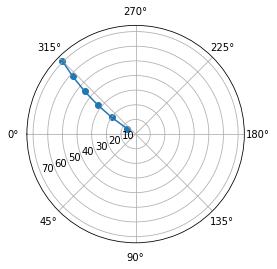

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('W', offset=0)

c = ax.scatter(np.radians(az_pt_grid), 90.-el_pt_grid)
l = ax.plot(np.radians(az_pt_grid), 90.-el_pt_grid)

# for i in range(n_alt):
#     az = np.radians(az_grid[i])
#     el = np.zeros(len(az))+alt_grid[i].deg
#     c = ax.scatter(az, 90.-el)


Now for each Az/El pointing try to find a bright star to point.

In [9]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                                    lat=-30.244728*u.deg,
                                                    height=2663.0*u.m)

In [10]:
customSimbad = Simbad()
customSimbad.add_votable_fields('distance_result', "fluxdata(V)")
customSimbad.TIMEOUT = 10

In [11]:
async def find_target_from_az_el(az, el, location):
    """A method to point.
    """
    
    current_time = Time.now()

    print('[Az, El] is [{},{}]'.format(az,el))
    elaz = AltAz(alt=el, az=az, 
                 obstime=current_time, 
                 location=location)

    radec = elaz.transform_to(ICRS)

    _ra = radec.ra.to_string(u.deg, decimal=True)
    _dec = radec.dec.to_string(u.deg, decimal=True, alwayssign=True)
    # radius of search
    r = Angle(2.*u.deg).to_string(u.deg, decimal=True)

    #criteria = f"region(circle,ICRS,{_ra} {_dec},{r}d) & Vmag < {mag_limit}"
    criteria = f"region(circle,ICRS,{_ra} {_dec},{r}d) & Vmag > {mag_limit_low} & Vmag < {mag_limit_high}"
    #print(criteria)
    
    try:
        result_table = customSimbad.query_criteria(criteria)
    except Exception as e:
        print(f"Error getting target from Simbad. Skipping target {elaz!r}.")
        return -1

    if len(result_table) == 0:
        print(f"Could not find a suitable target around {elaz}.")
        return -1

    # sort by magnitude so first is the brightest 
    result_table.sort('FLUX_V')
    #print(result_table)

    target_radec = SkyCoord(Angle(result_table['RA'][0], unit=u.hour), 
                    Angle(result_table['DEC'][0], unit=u.deg), frame=ICRS)

    t_id = str(result_table['MAIN_ID'][0].decode())
    #t_id = str.encode(str(result_table['MAIN_ID'][0]))
    t_ra = result_table['RA'][0]
    t_dec = result_table['DEC'][0]
    t_mag = result_table['FLUX_V'][0]
    print(f"Pointing to {t_id:15}: {t_ra} {t_dec} (VMag:{t_mag:5.2f})")

    target = {'ra':  t_ra, 'dec': t_dec, 'mag': t_mag, 'id': t_id} 
    return target


In [12]:
# async def wait_center():
#     while True:
#         opt = input("Center telescope and choose action (press ?<enter>, for list of actions): ")
        
#         if opt == 'x':
#             print("Telescope centered. Adding data and continuing...")
#             #await atptg.cmd_pointAddData.start()
#             return 0
#         elif opt == 's':
#             print("Skipping...")
#             return 1
#         elif opt == 't':
#             print("Stopping test...")
#             return -1
#         elif opt == '?':
#             print("""Options are:
#             x - Telescope centered, add data and continue.
#             s - Skipp point and continue.
#             t - Terminate test.
#             """)
    

Store pass/fail pointings. 

In [14]:
pt_grid_done = np.zeros(n_alt*n_az, dtype=np.bool)

In [89]:
# get list of targets
targets = []
for i in range(len(az_pt_grid)):
#for i in range(1):
    try:
        target = await find_target_from_az_el(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg), location=location)
        targets.append(target)
        print(target)
    except Exception:
        print('no target found')
        pass
        

[Az, El] is [315.0 deg,19.0 deg]
Pointing to BD+25  2142    : 09 43 24.4060 +24 35 13.299 (VMag: 9.03)
{'ra': '09 43 24.4060', 'dec': '+24 35 13.299', 'mag': 9.03, 'id': 'BD+25  2142'}
[Az, El] is [317.5 deg,31.8 deg]
Pointing to HD  90419      : 10 26 31.7081 +14 15 03.830 (VMag: 9.01)
{'ra': '10 26 31.7081', 'dec': '+14 15 03.830', 'mag': 9.01, 'id': 'HD  90419'}
[Az, El] is [320.0 deg,44.6 deg]
Pointing to BD+06  2371    : 10 56 50.3207 +05 37 53.052 (VMag: 9.01)
{'ra': '10 56 50.3207', 'dec': '+05 37 53.052', 'mag': 9.01, 'id': 'BD+06  2371'}
[Az, El] is [322.5 deg,57.400000000000006 deg]
Pointing to HD 100519      : 11 34 04.0278 -04 09 57.795 (VMag: 9.01)
{'ra': '11 34 04.0278', 'dec': '-04 09 57.795', 'mag': 9.01, 'id': 'HD 100519'}
[Az, El] is [325.0 deg,70.2 deg]
Pointing to HD 104530      : 12 02 18.7067 -12 15 06.175 (VMag: 9.06)
{'ra': '12 02 18.7067', 'dec': '-12 15 06.175', 'mag': 9.06, 'id': 'HD 104530'}
[Az, El] is [327.5 deg,83.0 deg]
Pointing to HD 110589      : 12 43

In [90]:
csv = ''
for t in range(len(targets)):
    csv+=str('"'+targets[t]['id'])+'", '
print(csv)

"BD+25  2142", "HD  90419", "BD+06  2371", "HD 100519", "HD 104530", "HD 110589", 


In [13]:
target = await find_target_from_az_el(az=Angle((0)*u.deg),
                              el=Angle(80*u.deg), location=location)

[Az, El] is [0.0 deg,80.0 deg]
Pointing to HD  14176      : 02 17 04.1194 -21 50 49.736 (VMag: 9.02)


In [173]:
# save the list so we don't have to rerun this each time? 
# Not sure the best way to do that

In [174]:
import os
import sys
import logging

import numpy as np

from lsst.ts.standardscripts.auxtel.attcs import ATTCS
from lsst.ts.standardscripts.auxtel.latiss import LATISS

import lsst.observing.commands.calibrationStarVisit as calibrationStarVisit

Make sure that logs aren't lost

In [175]:
stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.ERROR

In [176]:
if True:
    attcs = ATTCS()
    latiss = LATISS(attcs.domain)

Execute this block if you want to pass `display=display` to `calibrationStarVisit.takeData`

In [33]:
if True:
    import lsst.afw.display as afwDisplay

    afwDisplay.setDefaultBackend("matplotlib" if False else "firefly")
    os.environ['FIREFLY_URL'] = "http://firefly01.cp.lsst.org:8080/firefly/"

    disp = afwDisplay.Display(1, name='pingraham', reopenPlot=True)

    if afwDisplay.getDefaultBackend() == "firefly":
        disp.getClient().display_url()
else:
    disp = None

In [ ]:
for repo in ["/mnt/dmcs/oods_butler_repo/repo",
             "/project/shared/auxTel",
             os.path.expanduser("~/Data/auxTel" "XX"),
            ]:
    if os.path.exists(repo):
        break

print(f"Using {repo}")  
repo = os.path.join(repo, "rerun", "quickLook")

if os.path.exists(repo):
    from lsst.daf.persistence import Butler
else:
    print(f"I can't find {repo}; using butler emulator")
    from lsst.ts.standardscripts.auxtel.butler import Butler
    
    latiss.domain.time_per_second = 0.0

butler = Butler(repo)
dataId = dict(dayObs="2020-02-21")

In [ ]:
repo = "/mnt/dmcs/oods_butler_repo/repo/rerun/quickLook"

if os.path.exists(repo):
    from lsst.daf.persistence import Butler
else:
    print(f"I can't find {repo}; using emulator")
    from lsst.ts.standardscripts.auxtel.butler import Butler
    
    latiss.domain.time_per_second = 0.0

butler = Butler(repo)
dataId = dict(dayObs="2020-02-21")

obslog = logging.getLogger()
obslog.setLevel(logging.INFO)

N.b. If `doPointingModel` and we don't have a pointing model, exec the next cell

In [ ]:
if False:
    await attcs.atptg.cmd_pointNewFile.start()

Define our own set of exposures and take them

In [ ]:
exposures = [
    ('BG40',    5, 'ronchi90lpmm')
]

await calibrationStarVisit.takeData(attcs, latiss, butler,
                                    objectName, exposures, updateFocus=False,
                                    logger=obslog, display=disp)

In [ ]:
for i in range(len(az_pt_grid)):
    
    if not pt_grid_done[i]:
        print(f"Pointing to: az={Angle(az_pt_grid[i]*u.deg)} / el {Angle(el_pt_grid[i]*u.deg)}")
        ret_val = await point(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg))
    else:
        print(f"Pointing {i} already completed. Skipping...")
        continue
        
    if ret_val == 0.:
        wait_ret_val = await wait_center()
        #await atptg.cmd_stopTracking.start()
        if wait_ret_val < 0:
            break
        pt_grid_done[i] = wait_ret_val == 0
    else:
        print(f"Failed to point to position {i} in the grid. continuing...")
            

print("Done...")

In [ ]:
pt_grid_done

In [ ]:
for i in range(len(az_pt_grid)):
    
    if not pt_grid_done[i]:
        print(f"Pointing to: az={Angle(az_pt_grid[i]*u.deg)} / el {Angle(el_pt_grid[i]*u.deg)}")
        ret_val = await point(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg))
    else:
        print(f"Pointing {i} already completed. Skipping...")
        continue
        
    if ret_val == 0.:
        wait_ret_val = await wait_center()
        await atptg.cmd_stopTracking.start()
        if wait_ret_val < 0:
            break
        pt_grid_done[i] = wait_ret_val == 0
    else:
        print(f"Failed to point to position {i} in the grid. continuing...")
            

print("Done...")

In [ ]:
pt_grid_done

In [ ]:
for i in range(len(az_pt_grid)):
    
    if not pt_grid_done[i]:
        print(f"Pointing to: az={Angle(az_pt_grid[i]*u.deg)} / el {Angle(el_pt_grid[i]*u.deg)}")
        ret_val = await point(az=Angle(az_pt_grid[i]*u.deg),
                              el=Angle(el_pt_grid[i]*u.deg))
    else:
        print(f"Pointing {i} already completed. Skipping...")
        continue
        
    if ret_val == 0.:
        wait_ret_val = await wait_center()
        await atptg.cmd_stopTracking.start()
        if wait_ret_val < 0:
            break
        pt_grid_done[i] = wait_ret_val == 0
    else:
        print(f"Failed to point to position {i} in the grid. continuing...")
            

print("Done...")

In [ ]:
await set_summary_state(atptg, State.STANDBY)

In [ ]:
await set_summary_state(atmcs, State.STANDBY)

In [ ]:
print(f"ATPtg: {State(atptg.evt_summaryState.get().summaryState)!r}")
print(f"ATMCS: {State(atmcs.evt_summaryState.get().summaryState)!r}")

# IGNORE FROM HERE ON

In [ ]:
current_time = Time.now()

elaz = AltAz(alt=alt_grid[i], az=Angle(az_grid[i][0]*u.deg), 
             obstime=current_time.tai, 
             location=location)

radec = elaz.transform_to(ICRS)

In [ ]:
print(elaz)
print(radec)

In [ ]:
customSimbad = Simbad()

In [ ]:
customSimbad.add_votable_fields('distance_result', "fluxdata(V)")

In [ ]:
_ra = radec.ra.to_string(u.deg, decimal=True)
_dec = radec.dec.to_string(u.deg, decimal=True)
r = Angle(4.*u.deg).to_string(u.deg, decimal=True)

criteria = f"region(circle,ICRS,{_ra} {_dec},{r}d) & Vmag < 7"
print(criteria)
result_table = customSimbad.query_criteria(criteria)
print(result_table)

In [ ]:
result_table.sort('FLUX_V')

In [ ]:
Angle(result_table['RA'][0], unit=u.hour), Angle(result_table['DEC'][0], unit=u.deg)

In [ ]:
target_radec = SkyCoord(Angle(result_table['RA'][0], unit=u.hour), 
                        Angle(result_table['DEC'][0], unit=u.deg), frame=ICRS)

In [ ]:
target_radec

In [ ]:
plt.hist(result_table['FLUX_V'])

In [ ]:
r = 1. * u.deg
result_table = Simbad.query_region(radec, radius=r)
# c = coordinates.SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')

In [ ]:
print(result_table.columns)

In [ ]:
print(result_table)

In [ ]:
print(az, el)

In [ ]:
Simbad.list_votable_fields()

In [ ]:
Simbad.get_field_description("fluxdata(filtername)")

In [ ]:
Simbad.get_field_description("V")

In [ ]:
Simbad.get_votable_fields()

In [ ]:
Simbad.ROW_LIMIT 

In [ ]:
Simbad.query_criteria?

In [ ]:
radec.ra.to_string(u.hour, decimal=False, sep=":")
radec.dec.to_string(u.deg, decimal=False, sep=":")

In [ ]:
Angle(r).to_string(u.deg)

In [15]:
0.2*141

28.200000000000003